## Summary
Presented here is a partial characterization of the Andor iXon Ultra 888, the new Shane telescope guide camera. The conventional amplifier (as opposed to the EM amp) is examined here, in all its possible settings. The results are given below. While taking this data, nonlineaty started to show at exposures above 55,000 for gain 2 mode, and 27,000 ADC for gain 1 mode. Default setting is gain 2.

Also shown here is the dark current performance. At an operating temperature of -60 °C, all dark current was less than 10^-2 electrons per second, so small as to be negligible. The analysis of the dark current shows some large non-uniformity, but those 'hot pixels' are stable. Preliminary analysis suggests that those hot pixels are stable over a range of temperatures.

### Conventional Amplifier Gain Performance

| Settings        | gain (e-/ADC) | Andor's value (e-/ADC) | read noise (e-)|
| --------------- | ------------ | ---------- | ----- |
| 0.1MHz, gain 2: | 0.80         | 0.79       | 2.86  |
| 0.1MHz, gain 1: | 3.39         | 3.32       | 4.83  |
| 1.0Mhz, gain 2: | 0.79         | 0.79       | 4.76  |
| 1.0Mhz, gain 1: | 3.41         | 3.30       | 6.46  |

* For the preamp gain 2 setting, it starts to exhibit non-liniarity due to ADC saturation at the 55,000 count level.
* For the preamp gain 1, it exhibits non-liniarity due to approaching full well at about 27,000 count. 
* Default setting is preamp gain 2
Here is a sample plot of the photon transfer curve, at gain 1, horizontal shift speed of 1.0 MHz. The calculations and resultant plots for all conventional amplifier settings are presented in the lower section of this document.
<img src="ptc_gain1_1MHz.png">
The gain of 3.41 was calculated from the slope of this curve. Note how the variance drops suddenly between 25,000-30,000 ADC; this is due to the pixels reaching full well. 

The plot below is a rough represenation of the linearity of the sensor response, for the same settings of gain 1, 1MHz.
<img src="exposure_time_vs_signal.png"> 
As can be seen, the signal scales mostly linear with exposure time, except as the signal approaches 100,000 e-. This non-linearity corresponds to full well. 



### Dark Current Performance
* Overall, the dark current is very low, at reasonable operating temperatures. 
* However, the characteristic dark current behavior is rather messy. About 1 in 20 pixels have an order of magnitude higher dark current response, resulting in two distinct average dark currents. Both responses were characterized through their guassian shaped distributions in the histogram of a stacked average dark current frame. The darkcurrent data was taken at -60 °C, with a horizontal shift speed of 1MHz and preamp gain 2, with a 5400s integration time.
  - 93% of pixels exhibited a darkcurrent of 10^-3 e-/s (primary dark current)
  - 5.7% exhibitied 10^-2 e-/s (secondary dark current)
  - and about 1.3% exhibited neither. Some of those pixels were random, but further analysis of the histogram of this 1.3% of pixels suggests a pattern of guassian groupings. If true, this would indicate a potential third and fourth average dark current response.
<img src="dark_current_histrogram_at_5400s,_-60c.png">
The histogram of the dark current frame shows two clear distributions, indicating two dark current responses.

<img src="darkcurrent_vs_temp.png">
Dark current frames were also measured at -40 °C and -25 °C, shown above. Those 3 points are enough to show exponential behavior in the dark current. The fraction of pixels showing higher dark current remained about the same at all temperatures, suggesting that the those hot pixels are stable over a range of temperatures.

<img src="log_plot_darkcurrent_vs_temp.png">
The log scale reveals that the two different dark currents are governed by the the same exponential curve (shown as a slope in the log plot), but differ in amplitude by one order of magnitude.

<img src="darkcurrent_frame_-60.png">
* The dark current response is stable, with the secondary dark current showing up as hot pixels in the image. Above is a sample dark current image, taken at -60 °C, with a 5400 second integration. The snow effect in the sample image is from the 1 in 20 hot pixels, while the large dots are cosmic ray events. 


<img src="darkcurrent_3s_10c.png">
* The dark current pattern changes with temperature. Above is a dark current frame taken at 10.5 °C (approx dome temperature), with a 3 second integration time. This pattern is also stable, consistantly appearing if the camera is at room temperature. If this pattern appears in image data, it is likely that the camera cooler is off.

### Sub-frames and Binning
* Sub-frames can be abitrary in size, provided they are the same size or smaller than the full crop dimensions. 
* Choosing a region of interest sub-frame will increase the readout speed, but only according to how many rows are cropped out. Cropping out columns does not increase readout speed. E.g., a 100x200 crop will read out at the same speed as a 1024x200 crop, and a 200x100 crop will read out twice as fast as a 100x200 crop.
* Binning is also abitrary, with one caveat: if the binning does not evenly divide into the frame crop, then the frame crop dimensions will be automatically and silently increased to the next size that does evenly divide

#### Further Notes

* Andor uses a feature referred to as 'bias clamp'. The effect of this feature is to fix the bias at 500 count, regardless of temperature, or gain setting.
* Andor documentation hints, but doesn't outright say, that the cooling and warming of the CCD needs to be controlled, to prevent undue stress on the chip. This temperature control appears to be handled by the application programming library, but we might want to ask them to say explicitly whether it does. Regardless, this becomes a concern in the event of improper shutdown, such as power loss. 
* While we are here, cooling performance.
  - Air cooling: peak cooling -94 C; ambient temp 20 C; Delta -114 C
  - Water cooling: peak cooling -98 C; ambient temp 20 C; Delta -118
  - I tested the camera for excessive vibration from the coolant pump. While vibrations were apparent in the coolant feed line, imaging a circular test pattern revealed no difference in sharpness between having the pump on or off.
* We did not measure charge transfer efficiency in this testing. It will be measured in any potential future tests of the Andor iXon Ultra camera.
* The application programming interface that Andor provides does not give access to overscan pixels.
* software bugs:
  - When queried, the camera gives the number of possible preamp settings as 3. Naturally, when trying to set the preamp to this 3rd setting, it fails, as there are only two possible preamp modes.
  - The fits header keywords will give contradictory info under certain circumstances, e.g. saying the gain is set to 2 in one keyword, and 1 in another
  - every now and again, it gets stuck in aquire mode. This has happened a confirmed 2 times, but has not been successfully reproduced.

In [53]:

from ccd_tools import *
from astropy.stats import sigma_clip
from scipy.stats import norm
from scipy.stats import linregress

def run_gain_analysis(main_path):
    
    # retrieve everything from the bias directory, ignoring files that are not fits
    bias_path = main_path + '/bias_frames'
    bias_files = get_filenames(bias_path, extension='.fits')

    # calculate a master bias for this temperature
    bias_mean, bias_median, stacked_bias_stddev = sigma_clipped_frame_stats(bias_files, path=bias_path, sigma=4.0)
    master_bias_frame = bias_mean[0]


    # start of main calculations:
    sub_dir_list = get_filenames(main_path, extension='exposure', include_path=True)
    print(sub_dir_list)  # print to check the output

    # this makes a list of lists, with each entry in the outer list corresponding to a
    # subdirectory, and each inner list being the file names withing that subdirectory
    sub_dir_filenames = []
    for sub_dir in sub_dir_list:
        # retrieve the filenames, checking the extension to make sure
        sub_dir_filenames.append(get_filenames(sub_dir, extension='.fits', include_path=True))

    # open an instance of DS9, to select a fairly flat region of data
    pyds9.ds9_targets()
    ds9 = pyds9.DS9(target='display')

    # in DS9, make a box region that avoids the edges of the image, to avoid any sort of trail-off or other edge
    # weirdness. Make sure that this region is flat to within a factor of two
    input('Pause while you select data. Press enter to continue')
    selection = get_ds9_region(ds9, get_data=False)

    # now pull the signal analysis: variance, signal level, and calculated gain
    variance = []
    signal = []
    gain = []
    exposure_time = []
    for exposure in sub_dir_filenames:
        for n, file in enumerate(exposure):
            with fits.open(exposure[n]) as frame1:
                with fits.open(exposure[n-1]) as frame2:
                    # store the exposure time
                    time = frame1[0].header['exposure']
                    exposure_time.append(float(time))
                    
                    # bias subtract the frame
                    frame1_data = frame1[0].data.astype('float32') - master_bias_frame
                    frame2_data = frame2[0].data.astype('float32') - master_bias_frame

                    # crop the data down to what was selected, and sigma clip it
                    frame1_data = sigma_clip(frame1_data[selection.ymin:selection.ymax, selection.xmin:selection.xmax], sigma=5.0)
                    frame2_data = sigma_clip(frame2_data[selection.ymin:selection.ymax, selection.xmin:selection.xmax], sigma=5.0)

                    frame_diff = frame1_data - frame2_data  # order of subtraction is arbitrary
                    frame_var = np.var(frame_diff)
                    frame_signal = np.median(np.asarray([frame1_data, frame2_data]))

                    # diagnostic stuff
                    # print('differential average:', np.mean(frame_diff))
                    # print('fraction of signal:', np.mean(frame_diff)/frame_signal)
                    # print('expected error:', np.sqrt(frame_var/frame_diff.size))
                    # # display the frame difference
                    # display_data(frame_diff)

                    # # histogram the frame difference
                    # plt.figure(exposure[n])
                    # plt.hist(frame_diff.compressed(), bins=np.arange(frame_diff.min(), frame_diff.max(), step=1), density=True)
                    # # add the fit of a guassian to this
                    # gmean, gstd = norm.fit(frame_diff.compressed())
                    # print('norm fit parameters:', gmean, gstd)
                    # print('std dev of data used in fit:', np.std(frame_diff.compressed()))
                    # xmin, xmax = plt.xlim()
                    # x = np.linspace(xmin, xmax, 1000)
                    # y = norm.pdf(x, gmean, gstd)
                    # plt.plot(x, y)

                    # # histogram one of the frames
                    # plt.figure(exposure[n] + 'signal')
                    # plt.hist(frame1_data.flatten(), bins=np.arange(-350.5, 350.5, step=1) + 3800)
                    # plt.show()

                    # store signal
                    signal.append(frame_signal)
                    # store variance
                    variance.append(frame_var)
                    # store calculated gain, gain=signal/var * sqrt(2)
                    gain.append(frame_signal/frame_var * 2)


    plt.figure('gain vs signal')
    plt.scatter(signal, gain)
    plt.ylim(0, 4)
    plt.title('gain measured from difference frames, as a function of signal from those frames.')
    plt.ylabel('gain (e-/ADC)')
    plt.xlabel('signal from a difference of frames (ADC)')

    plt.figure('ptc')
    plt.scatter(signal, variance)
    plt.title('photon transfer curve')
    plt.xlabel('Signal (ADC)')
    plt.ylabel('Variance (ADC)')

    # clipped the signal to 85% of max signal. This should avoid non-liniarity at near max well, or max adc
    clipped_signal = np.ma.masked_greater(signal, .85*max(signal))
    fitresult = linregress(clipped_signal.compressed(), np.ma.array(variance, mask=clipped_signal.mask).compressed())
    slope = fitresult[0]
    intercept = fitresult[1]
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)
    y = intercept + slope*x
    plt.plot(x, y, label='fit to slope')
    plt.legend()

    measured_gain = 1/slope*2
    print('Gain measured from slope of ptc:', measured_gain)
    
    # calculate read noise, from the average deviation of the bias frames
    bias_dev_list = []
    for bias_frame in bias_files:
        with fits.open(bias_path + '/' + bias_frame) as bias_hdul:
            bias_frame1 = bias_hdul[0].data
            mean, median, stddev = sigma_clipped_stats(bias_frame1, sigma=4.0)
            bias_dev_list.append(stddev)

    avg_bias_stddev = np.average(bias_dev_list)

    print('read noise:', avg_bias_stddev*measured_gain)
    
    plt.figure('exposure time vs signal')
    plt.scatter(exposure_time, np.asarray(signal)*measured_gain)
    plt.title('signal as a function of integration time')
    plt.xlabel('itegration time (s)')
    plt.ylabel('signal (e-)')
    
    return measured_gain



['/home/lee/Data/illumination_data_gain1_1MHz/64s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/2s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/16s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/40s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/4s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/point5s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/32s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/1s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/48s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 3.4033217458504414
read noise: 6.458300939458318


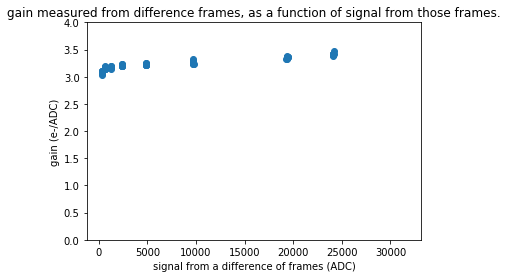

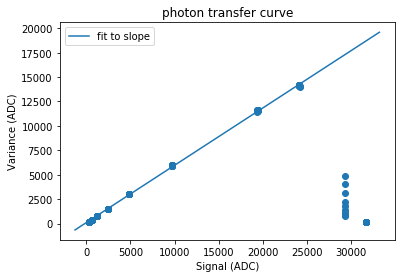

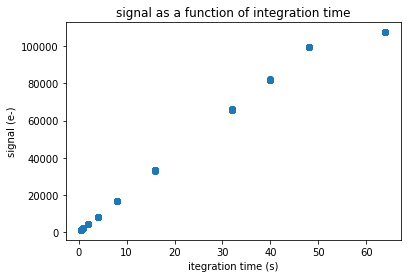

In [54]:
# analyze the 1MHz, gain 1 setting. 
data_path = '/home/lee/Data/illumination_data_gain1_1MHz'
# main_path = '/home/lee/Data/illumination_data_gain2_100kHz'
gain = run_gain_analysis(data_path)

['/home/lee/Data/illumination_data_gain2_1MHz/2s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/16s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/24s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/4s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/point5s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/point1s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/32s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/1s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 0.7957404924843737
read noise: 4.744783902113936


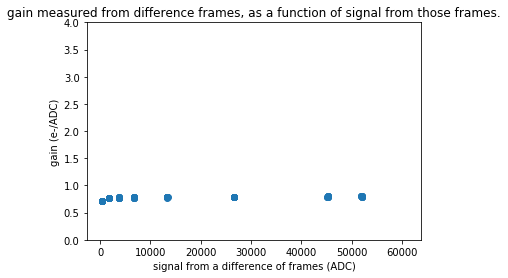

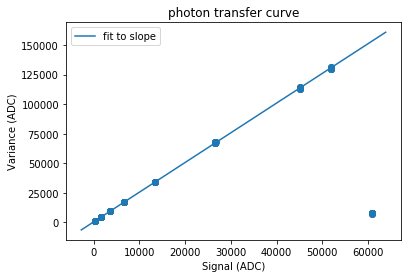

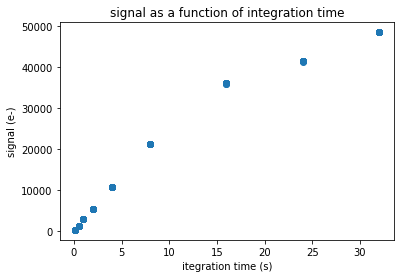

In [58]:
# analyze the 1MHz, gain 2 setting. 
data_path = '/home/lee/Data/illumination_data_gain2_1MHz'
gain = run_gain_analysis(data_path)

['/home/lee/Data/illumination_data_gain1_100kHz/2s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/16s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/40s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/4s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/point5s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/32s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/1s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/48s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 3.4017837128970063
read noise: 4.84543169168779


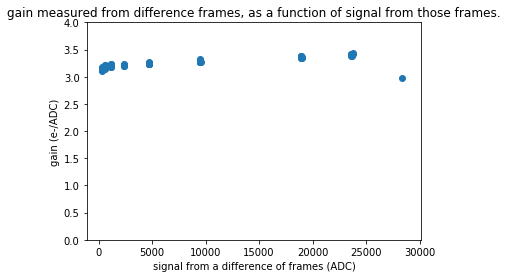

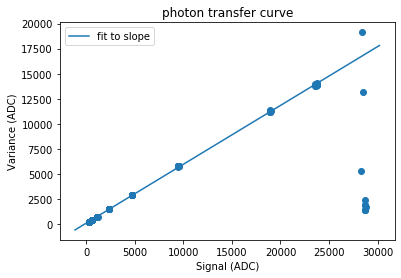

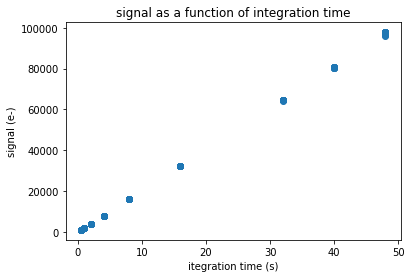

In [56]:
# analyze the 0.1MHz, gain 1 setting. 
data_path = '/home/lee/Data/illumination_data_gain1_100kHz'
gain = run_gain_analysis(data_path)

['/home/lee/Data/illumination_data_gain2_100kHz/2s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/16s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/24s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/4s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/point5s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/32s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/1s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 0.7964285610690153
read noise: 2.8520275484998954


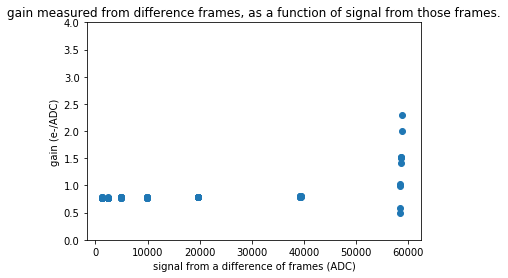

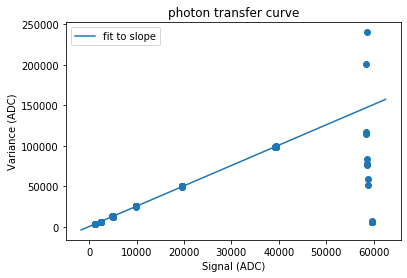

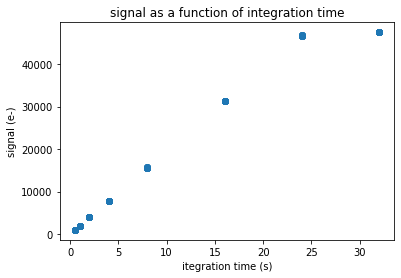

In [57]:
# analyze the 0.1MHz, gain 2 setting. 
data_path = '/home/lee/Data/illumination_data_gain2_100kHz'
gain = run_gain_analysis(data_path)